---
# Install the required packages

If needed install the following packages:

In [1]:
#!pip install tensorflow keras

---
# Imports

In [2]:
# Write your code here. Add as many boxes as you need.
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of **R peak interval** for a patient. Your task involves employing deep learning methods to forecast the **required measurements**. To accomplish this you will be using a patient's ECG measurements from the MITDB database, which consists of the following values:

- R peak Interval (int: the time the R peak appeared)
- Beat Annotation (string: the beat type)
- Episode Annotation (string: the episode type)

**Note: You are required to perform this laboratory assignment on your local machine.**


# Read the data

You are required to load the given data from the `201_cleaned.ann` file (csv format). Load the data into a `pandas dataframe` and display the first 5 rows of the dataframe.

In [3]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('201_cleaned.ann')
data.head()

,R peak Interval,Beat Annotation,Episode Annotation
0,55,N,(AFIB
1,144,N,(AFIB
2,238,N,(AFIB
3,314,N,(AFIB
4,412,N,(AFIB


---
# EDA

## Explore the Beat Annotation Distribution

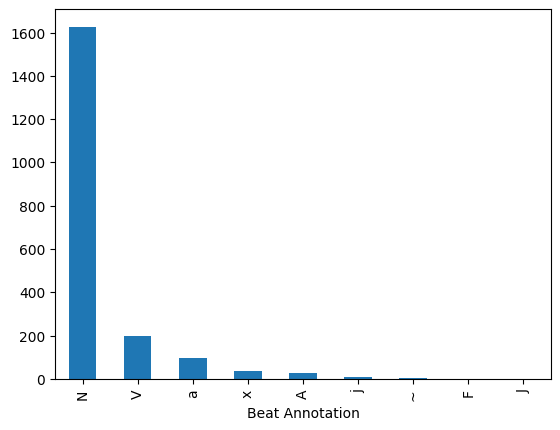

In [4]:
# Write your code here. Add as many boxes as you need.
data['Beat Annotation'].value_counts().plot(kind='bar')
plt.show()

## Explore the Episode Annotation Distribution

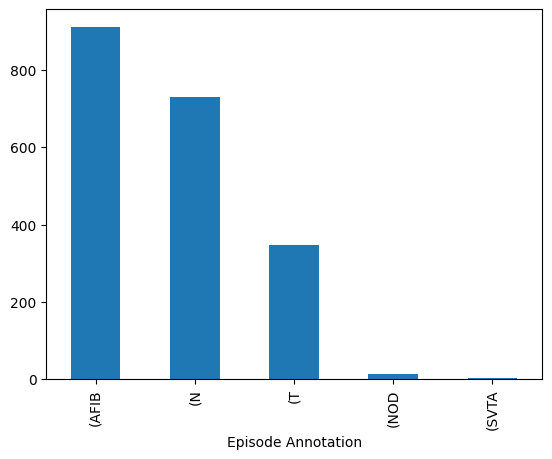

In [5]:
# Write your code here. Add as many boxes as you need.
data['Episode Annotation'].value_counts().plot(kind='bar')
plt.show()

---
# Feature Engineering

## Re-Labeling the data (Beat Annotation)

Re-label the data into 3 beat types:
- Normal Beat (N)
- Ventricular Beat (V)
- Other Beats (Other)

In [6]:
# Write your code here. Add as many boxes as you need.
def relabel_beat_annotation(annotation):
    if annotation == 'N':
        return 'Normal Beat'
    elif annotation == 'V':
        return 'Ventricular Beat'
    else:
        return 'Other Beats'


Check that the mapping worked:

In [7]:
# Write your code here. Add as many boxes as you need.
data['Relabeled Beat'] = data['Beat Annotation'].apply(relabel_beat_annotation)
data['Relabeled Beat'].value_counts()

Relabeled Beat
Normal Beat         1625
Ventricular Beat     198
Other Beats          181
Name: count, dtype: int64

## Re-Labeling the data (Episode Annotation)

Re-label the data into 3 beat types:
- Normal Episode: (N
- Atrial Fibrillation: (AFIB
- Other Episode: (Other

In [8]:
# Write your code here. Add as many boxes as you need.
def relabel_episode_annotation(annotation):
    if annotation == '(N':
        return 'Normal Episode'
    elif annotation == '(AFIB':
        return 'Atrial Fibrillation'
    else:
        return 'Other Episode'

Check that the mapping worked:

In [9]:
# Write your code here. Add as many boxes as you need.
data['Relabeled Episode'] = data['Episode Annotation'].apply(relabel_episode_annotation)
data['Relabeled Episode'].value_counts()

Relabeled Episode
Atrial Fibrillation    911
Normal Episode         730
Other Episode          363
Name: count, dtype: int64

## Create Lag Features (5 prev values) for R peak Interval measurement

Apply a lag for the R peak Interval, creating a set of features representing the historical patient data. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [10]:
data.columns

Index(['R peak Interval', 'Beat Annotation', 'Episode Annotation',
       'Relabeled Beat', 'Relabeled Episode'],
      dtype='object')

In [11]:
# Write your code here. Add as many boxes as you need.
for i in range(1, 6):
    data[f'R_Peak_Lag_{i}'] = data['R peak Interval'].shift(i)

data = data.dropna()

Check that the mapping worked:

In [12]:
# Write your code here. Add as many boxes as you need.
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,Relabeled Beat,Relabeled Episode,R_Peak_Lag_1,R_Peak_Lag_2,R_Peak_Lag_3,R_Peak_Lag_4,R_Peak_Lag_5
5,493,N,(AFIB,Normal Beat,Atrial Fibrillation,412.0,314.0,238.0,144.0,55.0
6,562,N,(AFIB,Normal Beat,Atrial Fibrillation,493.0,412.0,314.0,238.0,144.0
7,682,N,(AFIB,Normal Beat,Atrial Fibrillation,562.0,493.0,412.0,314.0,238.0
8,776,N,(AFIB,Normal Beat,Atrial Fibrillation,682.0,562.0,493.0,412.0,314.0
9,866,N,(AFIB,Normal Beat,Atrial Fibrillation,776.0,682.0,562.0,493.0,412.0


## Generate R-R interval features


For the past 5 R peak intervals ($R_{i}, i \in \{-1, -2, -3, -4, -5\}$), generate the 4 R-R intervals as features.

$RR_{i} = R_{i} - R_{i-1}$

In [13]:
# Write your code here. Add as many boxes as you need.
for i in range(1, 5):
    data[f'RR_{i}'] = data[f'R_Peak_Lag_{i}'] - data[f'R_Peak_Lag_{i+1}']

Additionally, generate the current R-R Interval, which we will be using as a target.  

$RR_{curr} = (R_{0} - R_{-1})$

In [14]:
# Write your code here. Add as many boxes as you need.
data['RR_curr'] = data['R peak Interval'] - data['R_Peak_Lag_1']

Check that the mapping worked:

In [15]:
# Write your code here. Add as many boxes as you need.
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,Relabeled Beat,Relabeled Episode,R_Peak_Lag_1,R_Peak_Lag_2,R_Peak_Lag_3,R_Peak_Lag_4,R_Peak_Lag_5,RR_1,RR_2,RR_3,RR_4,RR_curr
5,493,N,(AFIB,Normal Beat,Atrial Fibrillation,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,81.0
6,562,N,(AFIB,Normal Beat,Atrial Fibrillation,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,69.0
7,682,N,(AFIB,Normal Beat,Atrial Fibrillation,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,120.0
8,776,N,(AFIB,Normal Beat,Atrial Fibrillation,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,94.0
9,866,N,(AFIB,Normal Beat,Atrial Fibrillation,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,90.0


## Encode the categorical variables

In [16]:
# Write your code here. Add as many boxes as you need.
data = pd.get_dummies(data, columns=['Relabeled Beat', 'Relabeled Episode'], drop_first=True)

Check that the mapping worked:

In [17]:
# Write your code here. Add as many boxes as you need.
data.head()

,R peak Interval,Beat Annotation,Episode Annotation,R_Peak_Lag_1,R_Peak_Lag_2,R_Peak_Lag_3,R_Peak_Lag_4,R_Peak_Lag_5,RR_1,RR_2,RR_3,RR_4,RR_curr,Relabeled Beat_Other Beats,Relabeled Beat_Ventricular Beat,Relabeled Episode_Normal Episode,Relabeled Episode_Other Episode
5,493,N,(AFIB,412.0,314.0,238.0,144.0,55.0,98.0,76.0,94.0,89.0,81.0,False,False,False,False
6,562,N,(AFIB,493.0,412.0,314.0,238.0,144.0,81.0,98.0,76.0,94.0,69.0,False,False,False,False
7,682,N,(AFIB,562.0,493.0,412.0,314.0,238.0,69.0,81.0,98.0,76.0,120.0,False,False,False,False
8,776,N,(AFIB,682.0,562.0,493.0,412.0,314.0,120.0,69.0,81.0,98.0,94.0,False,False,False,False
9,866,N,(AFIB,776.0,682.0,562.0,493.0,412.0,94.0,120.0,69.0,81.0,90.0,False,False,False,False


---
# Model Training

## Remove unnecessary columns

For the purposes of training we will only be using the following columns as features:
- Beat Annotation
- Episode Annotation
- **All historical** 4 RR intervals

Moreover, the target column we will be forcasting is the ```current RR``` interval.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1999 entries, 5 to 2003
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   R peak Interval                   1999 non-null   int64  
 1   Beat Annotation                   1999 non-null   object 
 2   Episode Annotation                1999 non-null   object 
 3   R_Peak_Lag_1                      1999 non-null   float64
 4   R_Peak_Lag_2                      1999 non-null   float64
 5   R_Peak_Lag_3                      1999 non-null   float64
 6   R_Peak_Lag_4                      1999 non-null   float64
 7   R_Peak_Lag_5                      1999 non-null   float64
 8   RR_1                              1999 non-null   float64
 9   RR_2                              1999 non-null   float64
 10  RR_3                              1999 non-null   float64
 11  RR_4                              1999 non-null   float64
 12  RR_curr    

In [19]:
# Write your code here. Add as many boxes as you need.
columns = data.columns
features = [col for col in columns if col.startswith('RR_') or col.startswith('Relabeled')]
target = 'RR_curr'
if target in features:
    features.remove(target)
print(features)
print(target)

['RR_1', 'RR_2', 'RR_3', 'RR_4', 'Relabeled Beat_Other Beats', 'Relabeled Beat_Ventricular Beat', 'Relabeled Episode_Normal Episode', 'Relabeled Episode_Other Episode']
RR_curr


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [20]:
# Write your code here. Add as many boxes as you need.
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Neural Network (RNN / CRNN)

Create a deep (convolutional) recurrent neural network using:
- Minimum of 1 Convolutional Layer **(+2 points Optional)** and
- Minimum of 1 LSTM Layer

In [21]:
# Write your code here. Add as many boxes as you need.

**Reshape Data If Necessary**

In [22]:
# Write your code here. Add as many boxes as you need.
X_train_reshaped = np.expand_dims(X_train.values, axis=-1)
X_test_reshaped = np.expand_dims(X_test.values, axis=-1)
print(X_train_reshaped.shape)

(1599, 8, 1)


Compile and fit the model (Run only train 3 Epoch).

In [23]:
# Write your code here. Add as many boxes as you need.
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


C:\Users\Beqir\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 14096.1094 - mae: 111.4337 - val_loss: 18101.7148 - val_mae: 128.8640
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12791.7627 - mae: 105.1942 - val_loss: 14770.0752 - val_mae: 115.2196
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10072.4199 - mae: 91.0833 - val_loss: 11685.7090 - val_mae: 100.9760
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7276.8677 - mae: 74.5668 - val_loss: 8753.0410 - val_mae: 86.0285
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5329.4595 - mae: 60.7203 - val_loss: 6224.8340 - val_mae: 71.5346
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3619.8335 - mae: 47.2111 - val_loss: 4357.3037 - val_mae: 60.5621
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2584.7412 - mae: 39.7917 - val_loss: 3175.7166 - val_mae: 52.2168
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2268.0291 - mae: 36.6930 - val_loss: 2521.9954 - val_m

---
# Model Evaluation

Use the trained model to make predictions for the test set.

In [24]:
# Write your code here. Add as many boxes as you need.
y_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [25]:
# Write your code here. Add as many boxes as you need.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2 Score: {r2}")

MAE: 20.04430558204651
MSE: 1027.1358760694393
R^2 Score: 0.5046701548488253


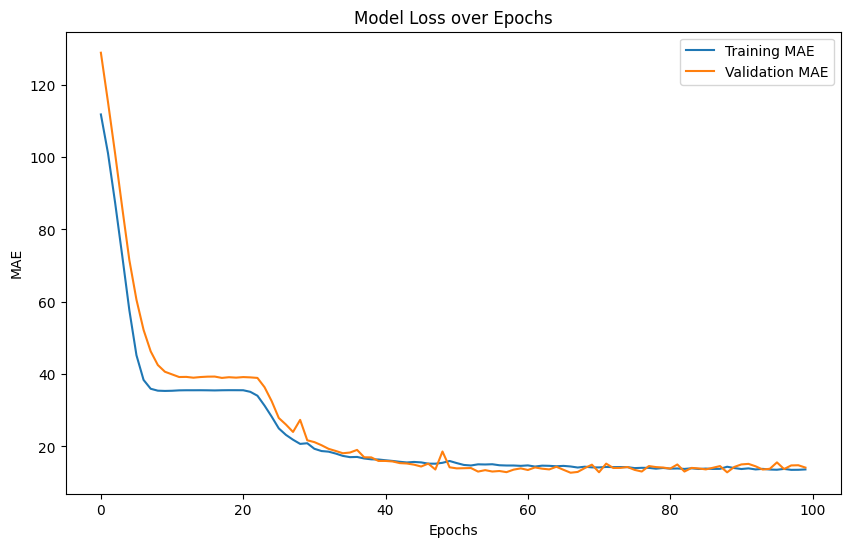

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()